In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [0]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [0]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [0]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [5]:
from google.colab import files
upload = files.upload()

Saving 01_heights_weights_genders.csv to 01_heights_weights_genders.csv


In [6]:
dflog=pd.read_csv("01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


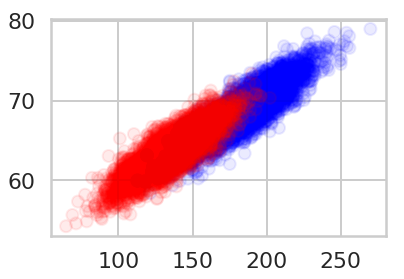

In [7]:
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.08);

In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    fold = KFold(nfold, shuffle=False, random_state=None)
    for train, test in fold.split(y): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [0]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, (dflog.Gender=="Male").values)

In [10]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print(max_score, best_C)

(0.9186666666666667, 0.001)


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.9216

In [12]:
from sklearn.model_selection import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:1

(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 {'C': 0.1},
 0.9186666666666666,
 {'mean_fit_time': array([0.00615239, 0.00777459, 0.00830617, 0.00847378, 0.0084856 ,
         0.00843043]),
  'mean_score_time': array([0.00050397, 0.00051904, 0.00056887, 0.00062346, 0.00058241,
         0.00059819]),
  'mean_test_score': array([0.91706667, 0.9184    , 0.91866667, 0.91866667, 0.91866667,
         0.91866667]),
  'mean_train_score': array([0.91703333, 0.9185    , 0.91846667, 0.91846667, 0.91846667,
         0.91846667]),
  'param_C': masked_array(data=[0.0001, 0.001, 0.1, 1, 10, 100],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'C': 0.0001},
   {'C': 0.001},
   {'C': 0.1},
   {'C': 1}

In [13]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.9224

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
!ls "/content/drive/My Drive"

'01 English and Metric Units.gsheet'
'01 English and Metric Units.xlsx'
'03 English Units with addition, subtraction, multiplication, division.gsheet'
'03 English Units with addition, subtraction, multiplication, division.xlsx'
'11_20186025 (10).gsheet'
'11_20186025 (11).gsheet'
'11_20186025 (1).gsheet'
'11_20186025 (2).gsheet'
'11_20186025 (3).gsheet'
'11_20186025 (4).gsheet'
'11_20186025 (5).gsheet'
'11_20186025 (6).gsheet'
'11_20186025 (7).gsheet'
'11_20186025 (8).gsheet'
'11_20186025 (9).gsheet'
 11_20186025.csv
 11_20186025.gsheet
'12_20186025 (1).gsheet'
'12_20186025 (2).gsheet'
'12_20186025 (3).gsheet'
'12_20186025 (4).gsheet'
'12_20186025 (5).gsheet'
'12_20186025 (6).gsheet'
'12_20186025 (7).gsheet'
 12_20186025.csv
 12_20186025.gsheet
'13_20186025 (1).gsheet'
'13_20186025 (2).gsheet'
 13_20186025.csv
 13_20186025.gsheet
'17 09 2018.gdoc'
'19 11 2018.gdoc'
'20186025 (1).gdoc'
'20186025 (2).gdoc'
 20186025.csv
 20186025.gdoc
 20186025.gsheet
 20186025-ICS_2019
 20186025-SEF_2019

In [16]:
data=np.load("/content/drive/My Drive/Colab Notebooks/imag.pix.npy", allow_pickle=True)
y=np.load("/content/drive/My Drive/Colab Notebooks/imag.lbl.npy", allow_pickle=True)
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [0]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

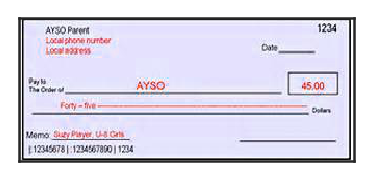

In [18]:
display_image(data[5])

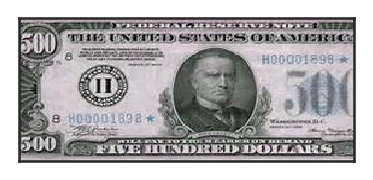

In [19]:
display_image(data[50])

### The curse of dimensionality: Feature engineering

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [21]:
print pca.explained_variance_ratio_.sum()

0.9425568123394886


In [22]:
pca.explained_variance_ratio_*100

array([35.92596698,  6.29318801,  4.10778347,  3.11950952,  2.81695972,
        2.28831619,  2.10127948,  1.87404973,  1.73264632,  1.53023757,
        1.42159658,  1.31839351,  1.24701508,  1.16381816,  1.09958304,
        1.06073049,  1.0074298 ,  0.98023778,  0.96055819,  0.91534661,
        0.9018507 ,  0.85212725,  0.83673597,  0.79690513,  0.7548759 ,
        0.72503214,  0.70819881,  0.67965465,  0.66091009,  0.64768647,
        0.62736656,  0.59473918,  0.58295253,  0.5743497 ,  0.5727152 ,
        0.55246318,  0.53850995,  0.53316783,  0.51653669,  0.49330395,
        0.48543046,  0.47728821,  0.47185071,  0.45596756,  0.44380226,
        0.43987795,  0.43389731,  0.42744887,  0.42117309,  0.40887271,
        0.40460159,  0.39316688,  0.38453652,  0.38160262,  0.37761442,
        0.36219209,  0.35623052,  0.34602078,  0.33794845,  0.33143011])

In [23]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,-2428.344215,-2133.776604,-328.317575,-1065.247031,79.777713,-425.031167,622.512767,-2490.333358,-858.422152,-1072.501724,276.764934,-1116.982947,712.883229,-787.610364,415.286590,-195.418750,472.591191,-428.836281,-610.955047,-588.495366,-266.557719,-986.901387,954.535186,1032.621855,570.557034,-45.368759,-114.123832,-515.963246,547.411657,-645.339468,68.923145,-726.534237,1254.857843,-619.474080,-139.341207,507.927398,291.666917,-249.084915,42.504491,-452.048955,772.853312,498.243873,-478.006938,492.431262,-233.528758,-98.614525,204.627863,-628.545782,-440.364249,-471.986519,100.527083,377.463156,-27.257247,-106.036377,-375.668523,281.819332,-264.330899,255.283137,297.807791
1,check,1,-22226.658684,-709.255919,-288.825609,-1300.638382,-792.091263,217.441037,1076.798907,-2115.048493,-875.672415,-1124.803839,-343.304060,-43.476127,547.816618,357.226060,-1761.827087,-371.536014,813.606157,294.622984,-939.936375,152.511993,-1120.983511,506.650794,-813.249716,718.277985,285.667990,-118.212619,813.768272,1142.346710,-356.342162,127.981913,-853.900853,583.376703,316.306075,172.415760,-684.664026,-670.982799,-104.473363,-163.146797,-145.246937,-376.457807,165.487560,55.462405,754.263220,-32.308761,347.462217,16.595248,-6.330016,259.020283,1126.653961,446.888581,-353.399480,-182.217786,-48.233242,-133.607001,594.015066,-479.764041,352.430911,-154.486794,-76.361671,331.181545
2,check,1,-17364.260784,-4252.027001,793.802831,-1362.069218,-374.232181,3142.097613,2514.236340,1443.865329,-121.135010,-419.741989,-2083.113140,1717.636830,-723.170201,-1240.265743,-310.292563,-1058.539265,1384.604950,-800.283324,-2598.541058,-882.002705,3385.781633,-392.536799,-3412.402314,1341.467660,-4755.411630,1030.444414,2197.969789,-687.064585,1374.102745,-2152.463528,-643.023319,1694.127563,1773.714345,-3172.471649,-784.773538,2323.179090,-3063.144883,3061.431580,835.660255,276.892709,1860.492412,-2784.891799,3966.707288,1353.586578,1046.004470,651.470862,-691.513748,-1372.885233,-95.526948,-2700.733213,-2626.763826,-2051.295196,1664.120598,895.638414,-1475.637051,-2733.989963,485.194534,-1161.565276,888.254794,-805.772682
3,check,1,-22847.256199,-900.591858,577.203169,-180.275455,-733.144774,-107.938950,1441.595556,-1070.094387,845.149720,-1389.779246,1471.708207,-725.164430,-577.805738,-258.193453,932.670993,170.211589,-297.601469,870.725658,-178.584057,1243.705765,554.991246,-167.343443,-339.115149,-371.499357,-931.831095,191.231343,1332.457118,93.635840,-264.214523,-491.033095,-150.353093,-80.366160,116.744174,785.168673,-179.743665,665.947329,422.309213,213.516155,82.628354,-434.335408,1289.019322,-859.114744,-923.428874,654.422445,392.418674,-590.788918,-570.541878,-474.041238,-876.046105,-1904.935946,53.229352,151.939330,397.332881,7.217169,-26.564021,1238.046628,-193.849894,178.727816,-51.446117,-1097.688144
4,check,1,-15868.672595,3259.492074,506.801087,-919.626350,2166.558896,-981.644807,-1669.751466,-391.350162,1735.766454,163.810249,-1626.061433,-555.841053,-862.190094,1722.469519,945.169218,-1135.119986,2140.758756,767.585455,-1092.060739,604.302842,-32.310622,82.528475,-511.518315,1108.811955,329.116739,-1213.371286,-700.311596,-715.840337,-143.086017,-933.744803,1033.754153,-3620.987339,2149.841664,-3412.076914,-842.505451,-2084.298074,1885.998007,2039.824511,2497.682131,-480.566290,26.968322,1453.510667,1121.442594,-1270.884689,-212.025579,-1010.551450,617.015451,837.928258,3032.695702,1601.264959,-895.367384,-2193.985749,338.070604,306.830914,3385.860361,2367.868966,-1110.383182,-1027.507031,1939.106749,1732.409337


In [0]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

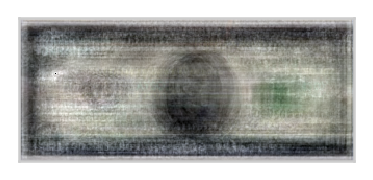

In [25]:
display_component(pca,0)

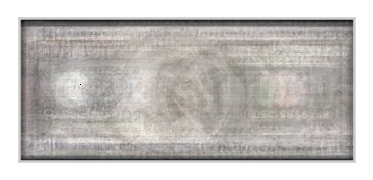

In [26]:
display_component(pca,1)

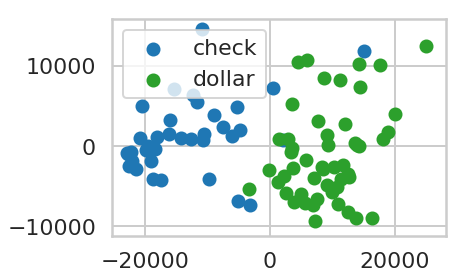

In [27]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

##Classifying in a reduced feature space with kNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy on training data: 1.00
Accuracy on test data:     0.91


(1, 1.0, 0.9142857142857143)

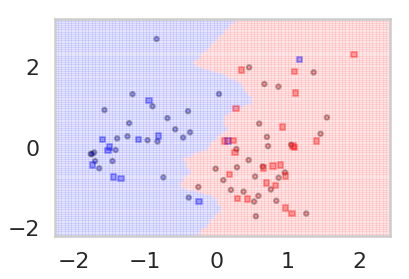

In [29]:
classify(Xs,ys,1)

Accuracy on training data: 0.67
Accuracy on test data:     0.46


(50, 0.6730769230769231, 0.45714285714285713)

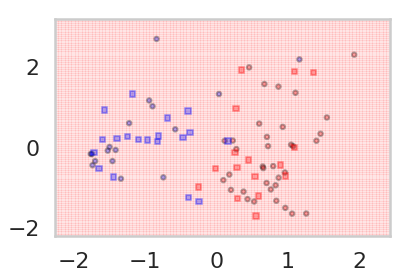

In [30]:
classify(Xs,ys,50)#run this a few times

In [0]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

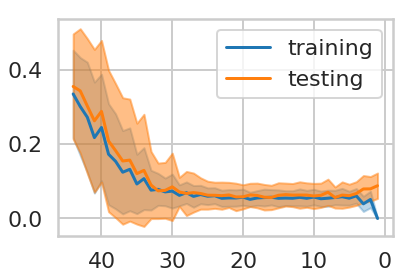

In [32]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

In [0]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

In [0]:
from sklearn.model_selection import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

In [36]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], 'label', 'check' )

BEST PARAMS {'n_neighbors': 15}
Accuracy on training data: 0.97
Accuracy on test data:     0.89


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


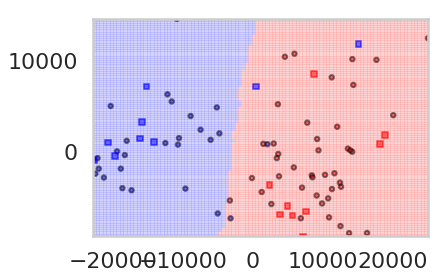

In [37]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


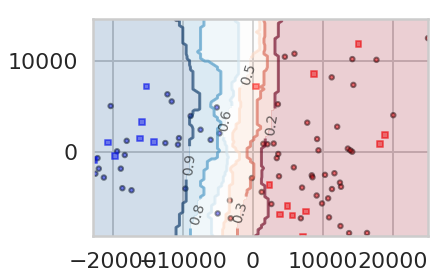

In [38]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[9, 0],
       [2, 7]])

##Logistic Regression

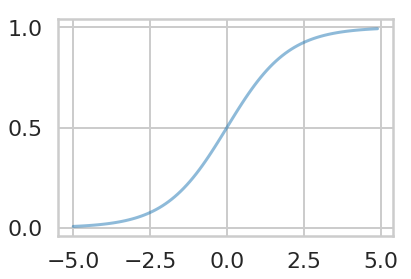

In [40]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [41]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [42]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


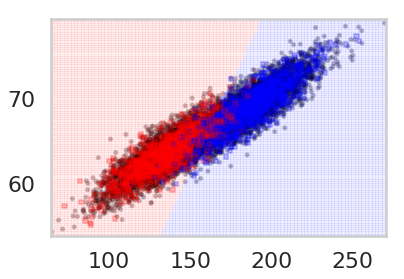

In [43]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

###Maximizing the probability of the training set.

In [44]:
clf_l.predict_proba(Xtest_l)

array([[4.94856131e-04, 9.99505144e-01],
       [3.93823341e-05, 9.99960618e-01],
       [9.89040660e-01, 1.09593398e-02],
       ...,
       [9.13424496e-01, 8.65755044e-02],
       [5.13530081e-02, 9.48646992e-01],
       [3.03651465e-03, 9.96963485e-01]])

###Discriminative classifier

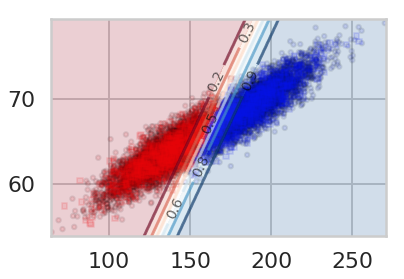

In [45]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);